In [1]:
projectdir = "C:/Users/Arman Angaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia"
using Pkg; Pkg.activate(projectdir)

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, Interact, LsqFit, CSV, Blink, Pipe, ProgressMeter
pyplot()

include("Turnover.jl")
include("test.jl")
using .Turnover

import TumorGrowth
include(projectdir*"/distribution_functions.jl")
include(projectdir*"/simulated_tumors/path_format.jl")

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-2910340528683583383\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-11392363128576541983\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-2910340528683583383\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

  Activating environment at `C:\Users\Arman Angaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`
┌ Info: Precompiling TumorGrowth [6c18b9fe-b06a-4315-99c1-34a00b453ec5]
└ @ Base loading.jl:1317


Loading Packages... Done!
Test Summary:             | Pass  Total
Applying turnover methods |    7      7


In [6]:
tumorinfo = dir_info(projectdir*"/simulated_tumors/2d")
append!(tumorinfo, dir_info(projectdir*"/simulated_tumors/2d/bulk"))
append!(tumorinfo, dir_info(projectdir*"/simulated_tumors/3d"))

N, b, d, mu, rho, Nthresh = 40000, 0.69, 0.3, 0.3, 30., 200
path = filter(t -> t.N == N && t.d == d && t.b == b && t.μ==mu && t.ρ ==rho && t.dim==3, tumorinfo).path |> rand
tumor = TumorGrowth.data_import(path)

htypes = unique(tumor.mutations)
freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)

orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh, htypes) ) )
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh for m in muts), htypes) )

(orphaned_tumor, estranged_tumor) .|> nrow |> println

(108, 91)


In [7]:
Ls = 0.2:0.1:1.
reps = 50
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = estranged_treeless(tumor)
            sum(res.isestranged)/sum(res.isgreen)
        end )
    end
;

### Infering `d` from orphaned turnover and `μ` from estranged turnover

In [8]:
using Distributions, NLsolve, Roots
z = nlsolve(x->cdf.(Normal(), x) .- 0.975, [1.]).zero[1]

1.9599639704623484

#### Get `q` given orphaned turnover of tumor

 d : 0.3
0.4667028488831674


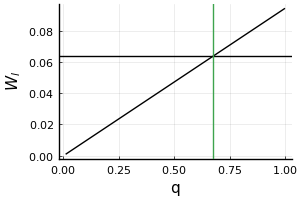

In [9]:
let W_l = orphaned_red_treeless(orphaned_tumor) |>
                df -> sum(df.isorphaned)/sum(df.isgreen)

    qval = min(1., 2*log(Nthresh)*W_l)
    println(" d : ", d)
    println(qval * b)
    plot(0.01:0.01:1., q->W_orphaned(q;N=Nthresh), legend=:none, size=(300,200), c=:black, xlab=:q, ylab=L"W_l")
    hline!([W_l], c=:black); vline!([qval], lab="")
end

 d : 0.3
0.4569798728647681


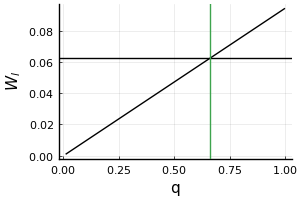

In [63]:
let W_l = orphaned_red_treeless(orphaned_tumor) |>
                df -> sum(df.isorphaned)/sum(df.isgreen)

    qval = min(1., 2*log(Nthresh)*W_l)
    println(" d : ", d)
    println(qval * b)
    plot(0.01:0.01:1., q->W_orphaned(q;N=Nthresh), legend=:none, size=(300,200), c=:black, xlab=:q, ylab=L"W_l")
    hline!([W_l], c=:black); vline!([qval], lab="")
end

W : 0.06921199171099464 ± 0.005472103484562195
q : 0.7334141953114833 ± 0.0579858818476078
d : 0.5060557947649235 ± 0.04001025847484938


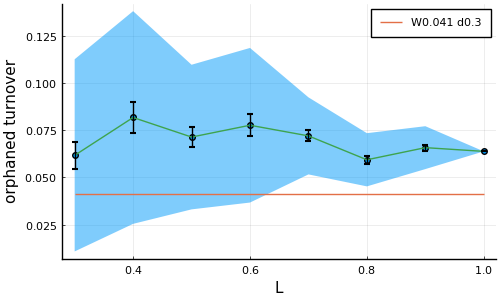

In [10]:
let Ls = 0.3:0.1:1.
    orphaned_tumors = map( Ls ) do L
        [TumorGrowth.reduced_μ(orphaned_tumor, L) for _=1:reps]
    end

    t = map(orphaned_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = orphaned_red_treeless(tumor)
            sum(res.isorphaned)/sum(res.isgreen)
        end )
    end

    qvals = map(t) do Ws
            2*log(Nthresh).*Ws
        end

    global d, b, Nthresh
    p = scatter(Ls, mean.(t), ribbon=std.(t), lab="", xlab=:L, ylab="orphaned turnover", size=(500,300))
    plot!(Ls, L-> W_orphaned(d/b; N=Nthresh),
        lab="W$(round(W_orphaned(d/b; N=Nthresh),digits=3)) d$d" )
    plot!(Ls, mean.(t), yerror=std.(t)./sqrt.(length.(t)), lab="" )

    println("W : ", mean(mean.(t)), " ± ", 1.96*std(mean.(t))/sqrt(length(t)) )
    println("q : ", mean(mean.(qvals)), " ± ", 1.96*std(mean.(qvals))/sqrt(length(t)) )
    println("d : ", mean(mean.(qvals))*b, " ± ", 1.96*std(mean.(qvals))/sqrt(length(t)) * b )
    p
end

#### Given `d` compute `μ` from estranged turnover of tumor

In [11]:
function bisection(f, interval, iter; precision=1e-9)
    xlow, xup = interval
    sign(f(xlow)) == sign(f(xup)) && error("no zero in interval $interval")
    any((isnan.(f.(interval)))) && error("f not defined on interval $interval")
    for i=1:iter
        xm = (xlow+xup)/2
        abs(f(xm)) < precision && return (xm, i)
        if sign(f(xm)) != sign(f(xlow))
            xup = xm
        else
            xlow = xm
        end
    end
    println(xup)
    error("no convergence within $iter steps")
end

bisection (generic function with 1 method)

μ : 0.3
0.1911699988134205


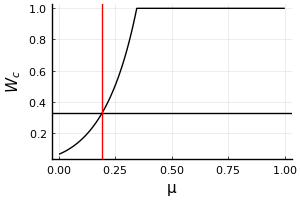

In [12]:
let d = 0.45
    global b, Nthresh, mu
    t = estranged_turnover
    
    W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen)

    mu_solve, n = bisection(mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d)))- W_c, [0.01,0.99], 100)
#     mu_solve = fzero(mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d)))- W_c, 0.01, 1.)

    println("μ : ", mu)
    println(mu_solve)
    plot(0.:0.001:1., mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d))), size=(300,200),
        legend=:none, c=:black, xlab=:μ, ylab=L"W_c")
    hline!([W_c], c=:black); vline!([mu_solve], c=:red)
end

#### Given `d` fit `μ` for sampled estranged turnover curves

μ : 0.3
mean fit : 0.20188043085146035
averaged fits : 0.20091084947496646 ± 0.0006023663576286096


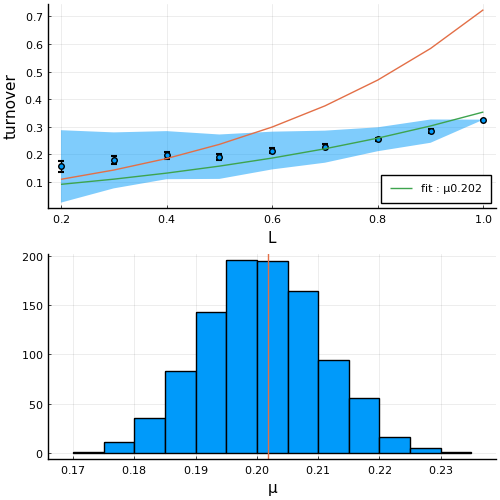

In [13]:
let d = 0.45
    t = estranged_turnover
    global b, Nthresh, mu
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=b, μ=mu*L, T=log(Nthresh)/(b-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [0.5])
    mu_fit = fit.param[1]

    p1 = scatter(Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:bottomright)
    plot!(Ls, model(Ls, [mu]), lab="" )
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [0.5]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram(mu_fits, xlab="μ", lab="")
    vline!([mu_fit], lab="")

    println("μ : ", mu)
    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1, p2, layout=(2,1), size=(500,500))
end

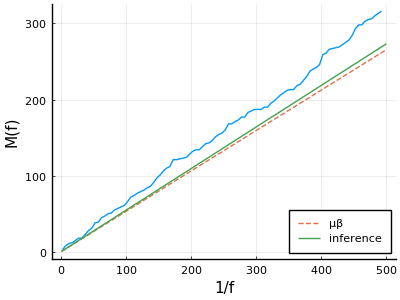

In [14]:
d_solve, mu_solve = 0.45, 0.19
res = 1/500

M(TumorGrowth.mutation_freqs(tumor).frequency, res = res, legend=:bottomright, lab="", size=(400,300))
plot!(1:1/res, x-> mu/(1-d/b)*x, lab="μβ", style=:dash)
plot!(1:1/res, x -> mu_solve/(1-d_solve/b)*x, lab="inference")

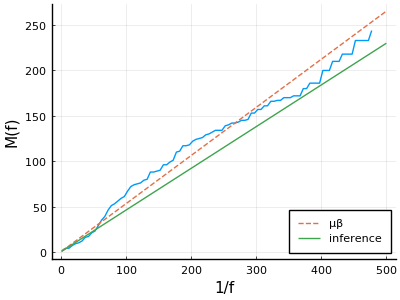

In [59]:
d_solve, mu_solve = 0.45, 0.16
res = 1/500

M(TumorGrowth.mutation_freqs(tumor).frequency, res = res, legend=:bottomright, lab="", size=(400,300))
plot!(1:1/res, x-> mu/(1-d/b)*x, lab="μβ", style=:dash)
plot!(1:1/res, x -> mu_solve/(1-d_solve/b)*x, lab="inference")

# Sampled tumors

In [168]:
using TumorGrowth: multi_region_sequencing, haplotypes, data_import
import TumorGrowth
include(projectdir*"/simulated_tumors/path_format.jl")

In [169]:
tumorinfo = dir_info(projectdir*"/simulated_tumors/2d/bulk")
first(filter(row -> row.N==40000, tumorinfo), 6)

,N,b,d,μ,ρ,dim,id,path
,Int64,Float64,Float64,Float64,Float64,Int64,Int64,String
1,40000,1.0,0.4,0.2,Inf,2,8830,C:/Users/Arman Angaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/simulated_tumors/2d/bulk\\tumor_N40000_b1.0_d0.4_μ0.2_ρInf_2d_id8830.csv


In [68]:
mus = Float64[]
dfits = Float64[]
mufits = Float64[]

let d = 0.4
    paths = filter(row -> row.d == 0.4, tumorinfo).path
    prog = Progress(length(paths))
    for path in paths
        parameters = read_params(path)
        b, mu = parameters.b, parameters.μ
        Nthresh = 500
        
        tumor = data_import(path)
        htypes = unique(tumor.mutations)
        freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)

        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh, htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh for m in muts), htypes) )
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |>
                df -> sum(df.isorphaned)/sum(df.isgreen)

        d_solve = min(1., 2*log(Nthresh)*W_l)
        
        # get mu
        
        Ls = 0.1:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    res = estranged_treeless(tumor)
                    sum(res.isestranged)/sum(res.isgreen)
                end )
            end
        
        function model(Ls, p)
            local mu = p[1]
            (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
            map( Ls ) do L
                min(1., W_estranged(d; b=b, μ=mu*L, T=log(Nthresh)/(b-d)))
            end
        end
        
        fit = curve_fit(model, Ls, mean.(estranged_turnover), [0.5])
        mu_fit = fit.param[1]
        
        push!(mus, mu)
        push!(dfits, d_solve)
        push!(mufits, mu_fit)
        
        next!(prog)        
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:56


In [69]:
bins = sort!(unique(mus))
dfits_binned = [ [dfits[findall(isequal(mu), mus)]...] for mu in bins]
mufits_binned = [ [mufits[findall(isequal(mu), mus)]...] for mu in bins]
length.(dfits_binned) |> println

[35]


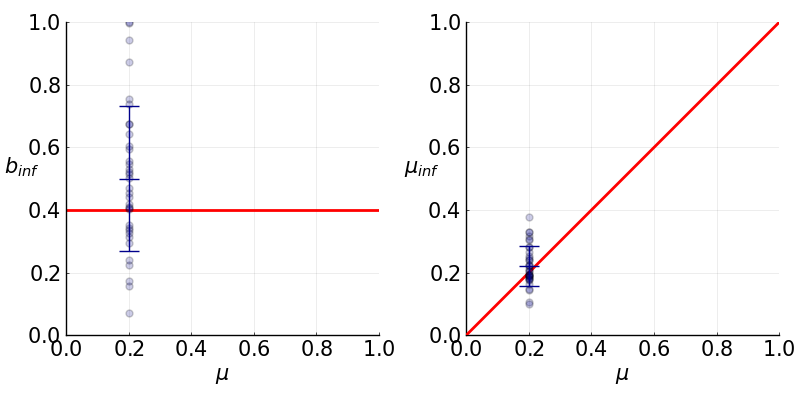

In [123]:
let d = 0.4
    p = plot(layout=(1,2), legend=:none, yguidefontrotation=-90, xlab=L"\mu", size=(800,400), aspect_ratio=1, ticks=0:0.2:1, guidefontsize=15, tickfont=15)

    hline!(p[1], [d], c=:red, lw=2.)
    scatter!(p[1], mus, dfits, ylab=L"b_{inf}",
        ylims=(0,1), xlims=(0,1), marker = (5, 0.2, :darkblue))
    scatter!(p[1], bins, mean.(dfits_binned), yerror = std.(dfits_binned),
        marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    plot!(p[2], 0:1,0:1, c=:red, lw=2.)
    scatter!(p[2], mus, mufits, ylab=L"\mu_{inf}", ylims=(0,1), xlims=(0,1),
        marker = (5, 0.2, :darkblue))
    scatter!(p[2], bins, mean.(mufits_binned), yerror = std.(mufits_binned),
        marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)

end

## Results

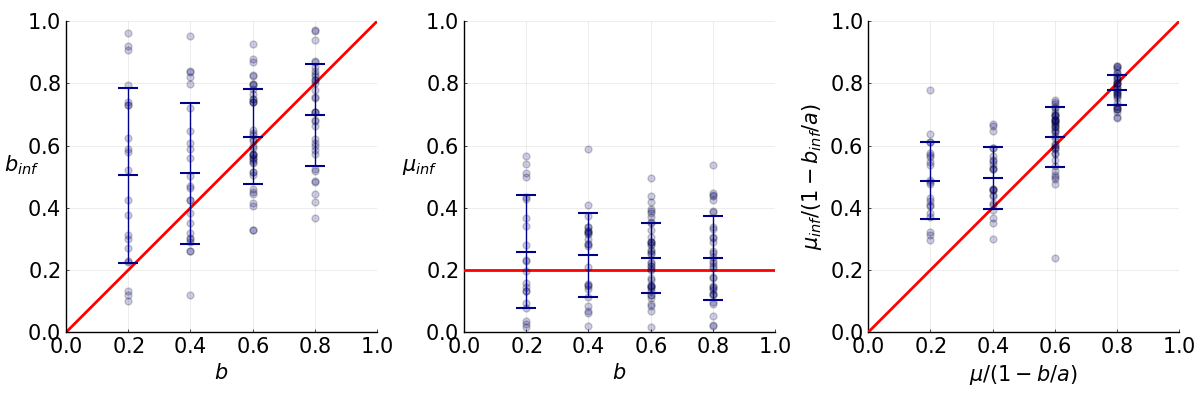

In [314]:
let mu = 0.2
    data = include("Turnover/inference_spatialdata_results.jl")[1]
    ds, dfits, mufits = data.ds, data.dfits, data.mufits
    bins = sort!(unique(ds))
    dfits_binned = [ [dfits[findall(isequal(mu), ds)]...] for mu in bins]
    mufits_binned = [ [mufits[findall(isequal(mu), ds)]...] for mu in bins]
    
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=1, xaxis=(L"b", (0,1), 0.:0.2:1.), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15)

    plot!(p[1], 0:1,0:1, c=:red, lw=2.)
    scatter!(p[1], ds, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    scatter!(p[2], ds, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:1, 0:1, c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    scatter!(p[3], ds, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
end

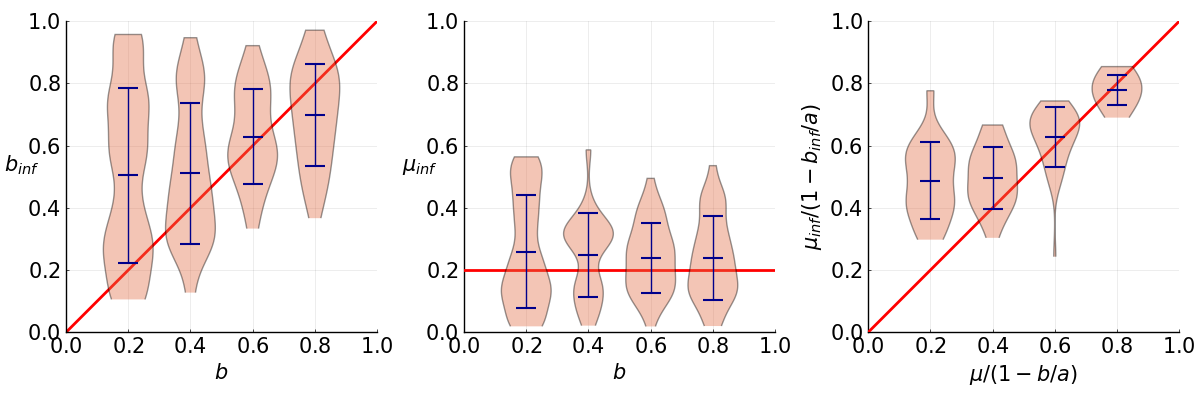

In [319]:
let mu = 0.2
    data = include("Turnover/inference_spatialdata_results.jl")[1]
    ds, dfits, mufits = data.ds, data.dfits, data.mufits
    bins = sort!(unique(ds))
    dfits_binned = [ [dfits[findall(isequal(mu), ds)]...] for mu in bins]
    mufits_binned = [ [mufits[findall(isequal(mu), ds)]...] for mu in bins]
    
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
end

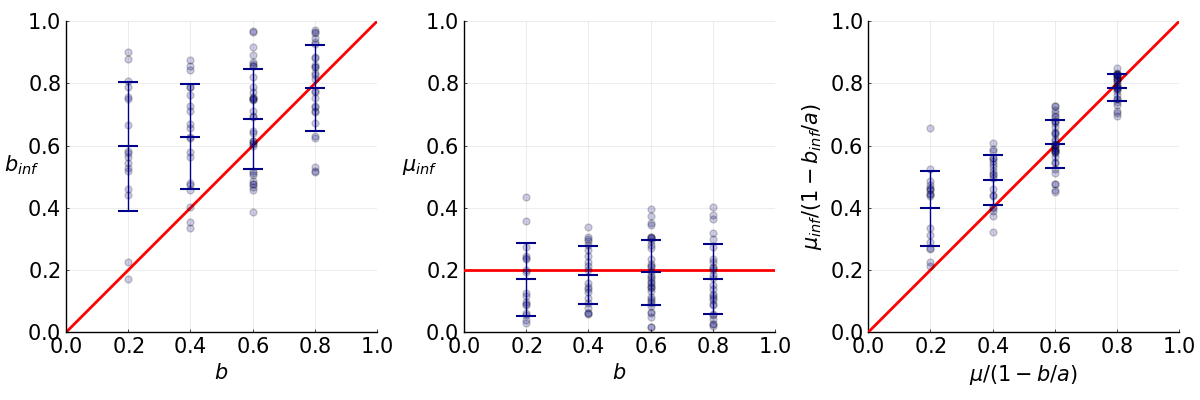

In [330]:
let mu = 0.2
    data = include("Turnover/inference_spatialdata_results.jl")[2]
    ds, dfits, mufits = data.ds, data.dfits, data.mufits
    bins = sort!(unique(ds))
    dfits_binned = [ [dfits[findall(isequal(mu), ds)]...] for mu in bins]
    mufits_binned = [ [mufits[findall(isequal(mu), ds)]...] for mu in bins]
    
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=1, xaxis=(L"b", (0,1), 0.:0.2:1.), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15)

    plot!(p[1], 0:1,0:1, c=:red, lw=2.)
    scatter!(p[1], ds, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    scatter!(p[2], ds, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:1, 0:1, c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    scatter!(p[3], ds, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
end

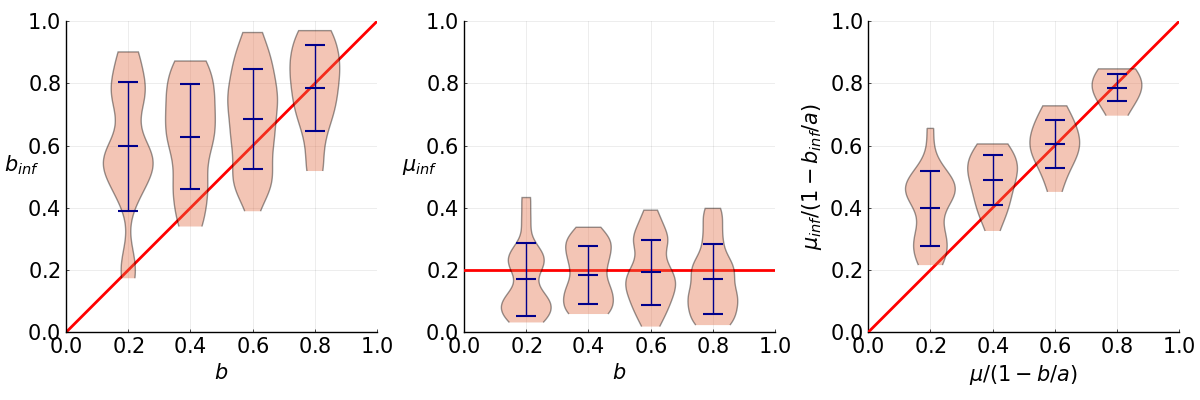

In [321]:
let mu = 0.2
    data = include("Turnover/inference_spatialdata_results.jl")[2]
    ds, dfits, mufits = data.ds, data.dfits, data.mufits
    bins = sort!(unique(ds))
    dfits_binned = [ [dfits[findall(isequal(mu), ds)]...] for mu in bins]
    mufits_binned = [ [mufits[findall(isequal(mu), ds)]...] for mu in bins]
    
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
end

In [329]:
# savefig("Turnover/turnover_plots/inference/inference_spatial_N400_n270_thesis.pdf")

## Infernce algorithms

In [282]:
ds = Float64[]
dfits = Float64[]
mufits = Float64[]

let mu = 0.2
    paths = filter(row -> row.N == 10000 && row.μ == 0.2 && row.d in 0.2:0.2:0.8, tumorinfo).path
    prog = Progress(length(paths))
    for path in paths
        parameters = read_params(path)
        b, d = parameters.b, parameters.d
        
        tumor = data_import(path)
#         TumorGrowth.reduced_μ!(tumor, 0.5)
        
        Nthresh = 200
        samples, sampletumor = TumorGrowth.multi_region_sequencing(tumor; n=200, cells_per_sample = 20)
        freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)
        for row in eachrow(sampletumor)
            mask = row.frequencies .>= 1/3
            row.mutations = filter(m-> freqs[m] > 1/(10000), row.mutations[mask])
        end

        htypes = unique(sampletumor.mutations)
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh, htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh for m in muts), htypes) )
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |>
                df -> sum(df.isorphaned)/sum(df.isgreen)

        d_solve = min(1., 2*log(Nthresh)*W_l)
        (isone(d_solve) || iszero(d_solve) || isnan(d_solve)) && continue
        
        # get mu
        
        Ls = 0.2:0.1:1.
        reps = 10
        estranged_tumors = map( Ls ) do L
            [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
        end

        estranged_turnover = map(estranged_tumors) do set
                filter!(!isnan, map(set) do tumor
                    res = estranged_treeless(tumor)
                    sum(res.isestranged)/sum(res.isgreen)
                end )
            end
        
        Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])
        
        function model(Ls, p)
            local mu = p[1]
            (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
            map( Ls ) do L
                min(1., W_estranged(d_solve; b=b, μ=mu*L, T=log(Nthresh)/(b-d_solve)))
            end
        end
        
        fit = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
        mu_fit = fit.param[1]
        mu_fit == (1-d_solve)/2 && continue
        
        push!(ds, d)
        push!(dfits, d_solve)
        push!(mufits, mu_fit)
        
        next!(prog)
    end
end

Progress:  80%|█████████████████████████████████        |  ETA: 0:02:07

In [306]:
dataset = include("Turnover/inference_spatialdata_results.jl")[1]
ds, dfits, mufits = dataset.ds, dataset.dfits, dataset.mufits;

In [283]:
bins = sort!(unique(ds))
dfits_binned = [ [dfits[findall(isequal(mu), ds)]...] for mu in bins]
mufits_binned = [ [mufits[findall(isequal(mu), ds)]...] for mu in bins]
length.(dfits_binned) |> println

[21, 24, 41, 33]


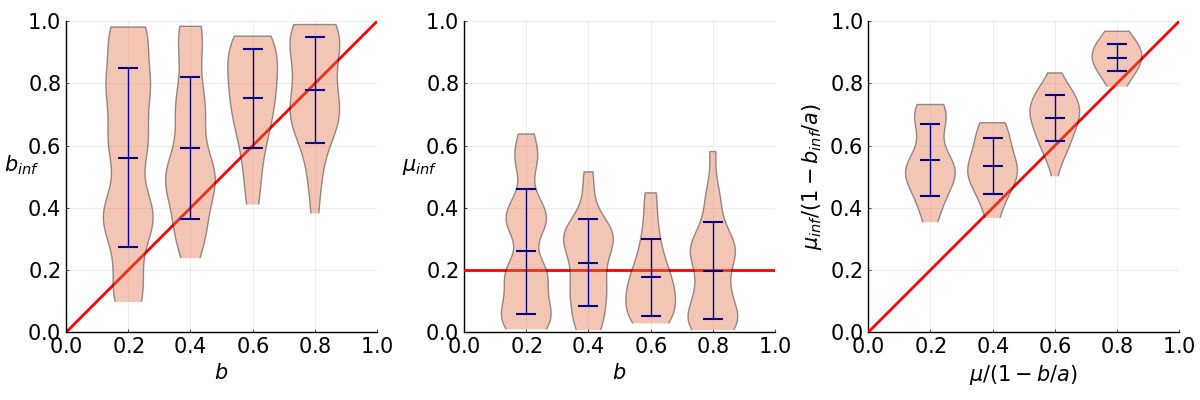

In [270]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 300, 200, 20, 1/3

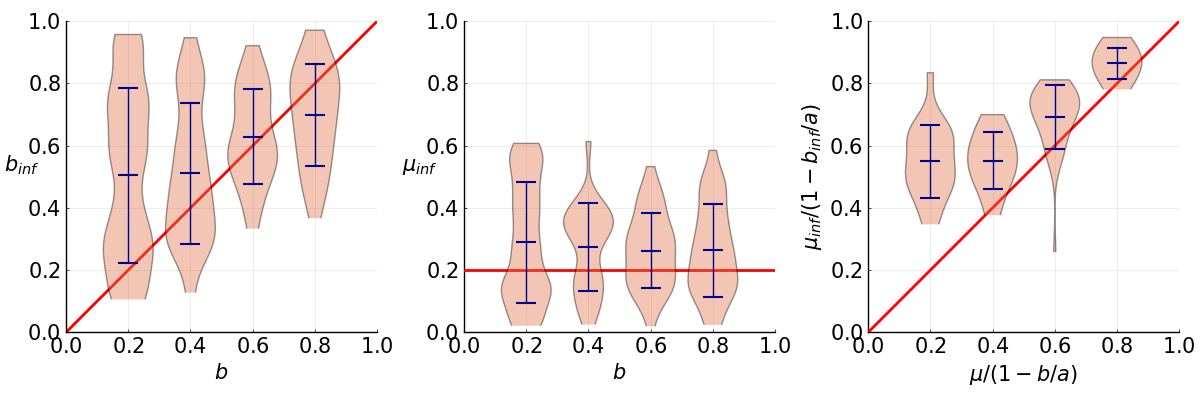

In [273]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 200, 200, 20, 1/3

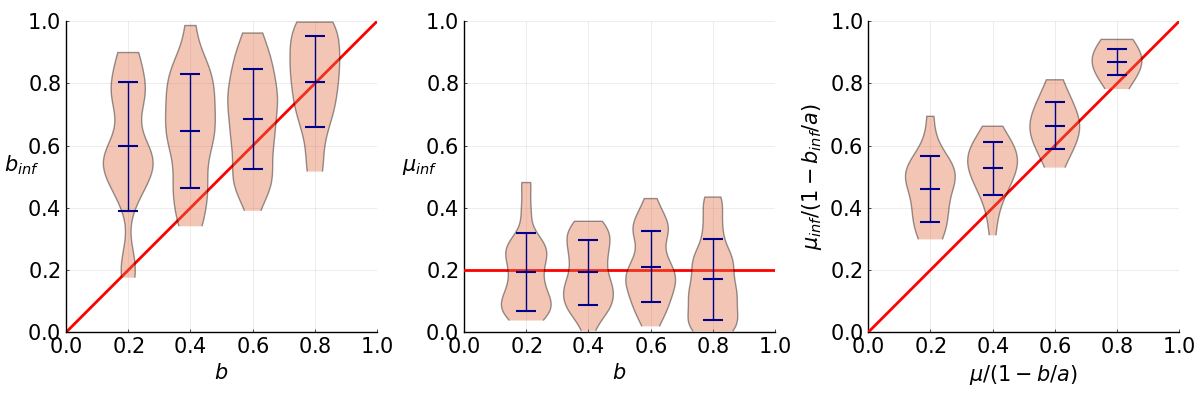

In [264]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 400, 270, 20, 1/3

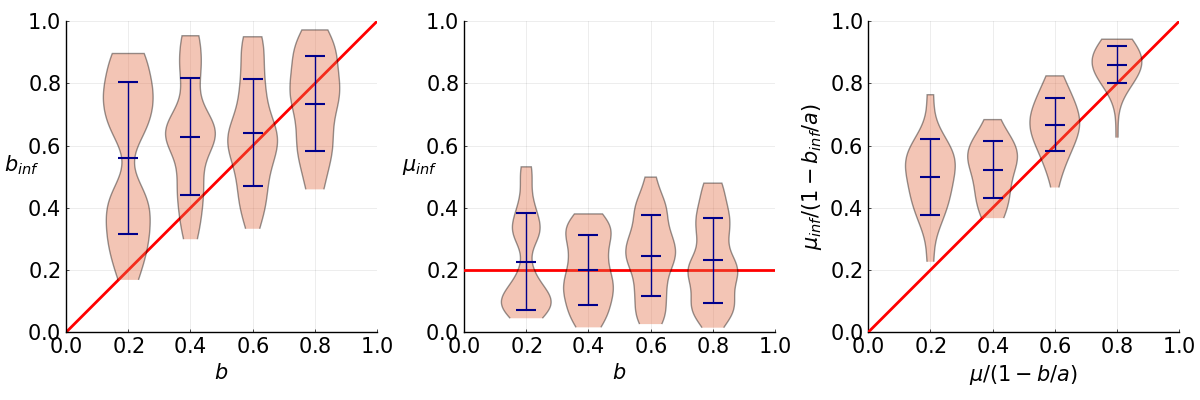

In [267]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 300, 270, 20, 1/3

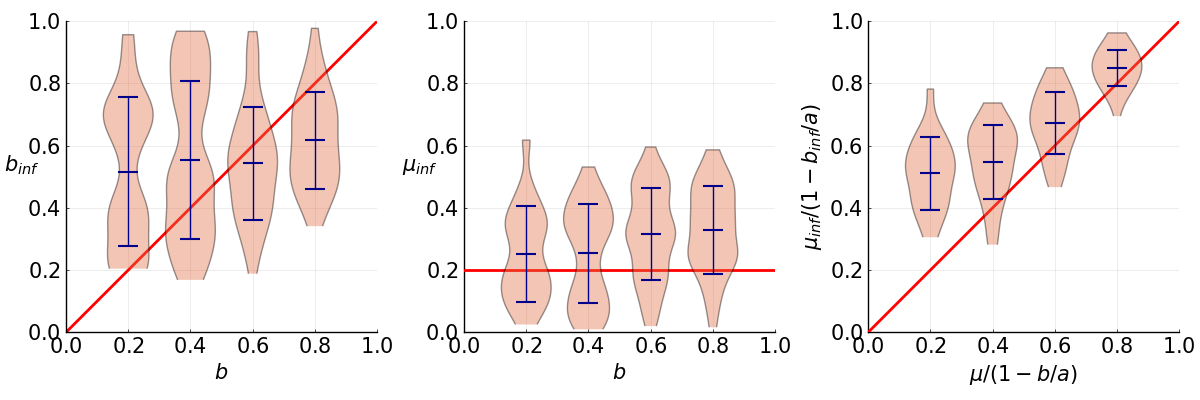

In [277]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 200, 270, 20, 1/3

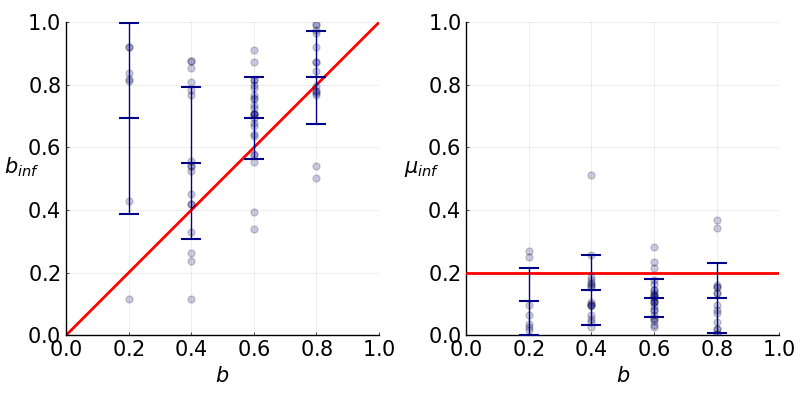

In [220]:
let mu = 0.2
    p = plot(layout=(1,2), legend=:none, yguidefontrotation=-90, size=(800,400),
             aspect_ratio=1, xaxis=(L"b", (0,1), 0:0.2:1), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15)

    plot!(p[1], 0:1,0:1, c=:red, lw=2.)
    scatter!(p[1], ds, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue))
    scatter!(p[1], bins, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    scatter!(p[2], ds, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue))
    scatter!(p[2], bins, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 100, 270, 20, 1/2

In [302]:
ds = Float64[]
dfits = Float64[]
mufits = Float64[]

let mu = 0.2
    paths = filter(row -> row.N == 10000 && row.μ == 0.2 && row.d in 0.2:0.2:0.8, tumorinfo).path
    prog = Progress(length(paths))
    for path in paths
        parameters = read_params(path)
        b, d = parameters.b, parameters.d
        
        tumor = data_import(path)
#         TumorGrowth.reduced_μ!(tumor, 0.5)
        
        Nthresh = 400
        samples, sampletumor = TumorGrowth.multi_region_sequencing(tumor; n=270, cells_per_sample = 20)
        freqs = TumorGrowth.mutation_freqs(tumor) |> seq -> Dict(seq.mutation .=> seq.frequency)
        for row in eachrow(sampletumor)
            mask = row.frequencies .>= 1/3
            row.mutations = filter(m-> freqs[m] > 1/(10000), row.mutations[mask])
        end

        htypes = unique(sampletumor.mutations)
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh, htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh for m in muts), htypes) )
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |>
                df -> sum(df.isorphaned)/sum(df.isgreen)

        d_solve = min(1., 2*log(Nthresh)*W_l)
        isone(d_solve) && continue
        
        # get mu
        
        W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen)

        try 
            mu_fit, n = bisection(mu -> min(1., W_estranged(d_solve; b=b, μ=mu, T=log(Nthresh)/(b-d_solve)))- W_c, [0.01,0.99], 100)
            push!(ds, d)
            push!(dfits, d_solve)
            push!(mufits, mu_fit)
            next!(prog)
        catch e
        end
        
    end
end

Progress:  67%|████████████████████████████             |  ETA: 0:04:15

In [303]:
bins = sort!(unique(ds))
dfits_binned = [ [dfits[findall(isequal(mu), ds)]...] for mu in bins]
mufits_binned = [ [mufits[findall(isequal(mu), ds)]...] for mu in bins]
length.(dfits_binned) |> println

[17, 20, 35, 27]


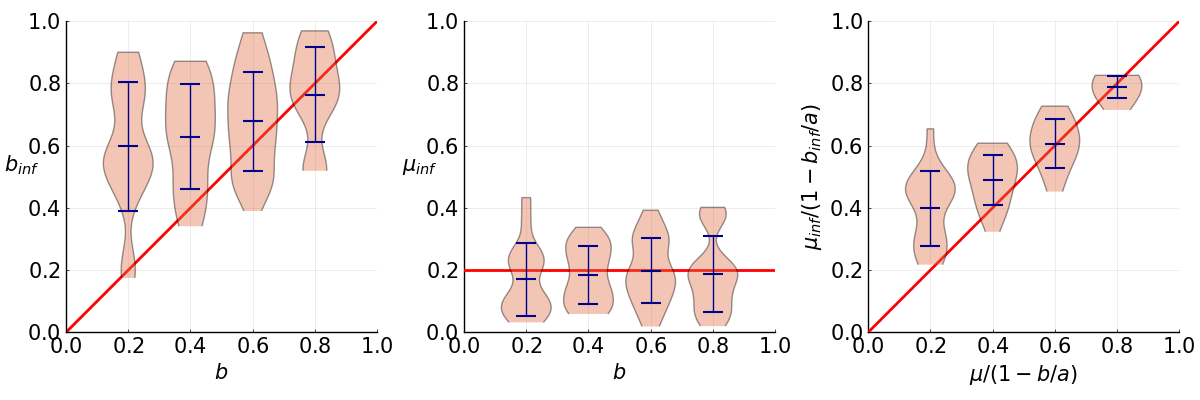

In [169]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

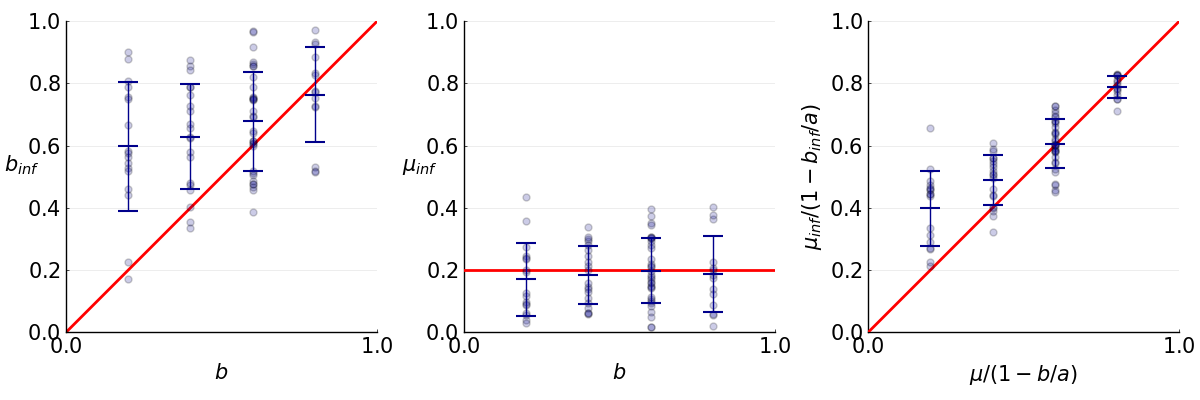

In [159]:
let mu = 0.2
    scalex = 1
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    scatter!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    scatter!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    scatter!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 400, 270, 20, 1/3

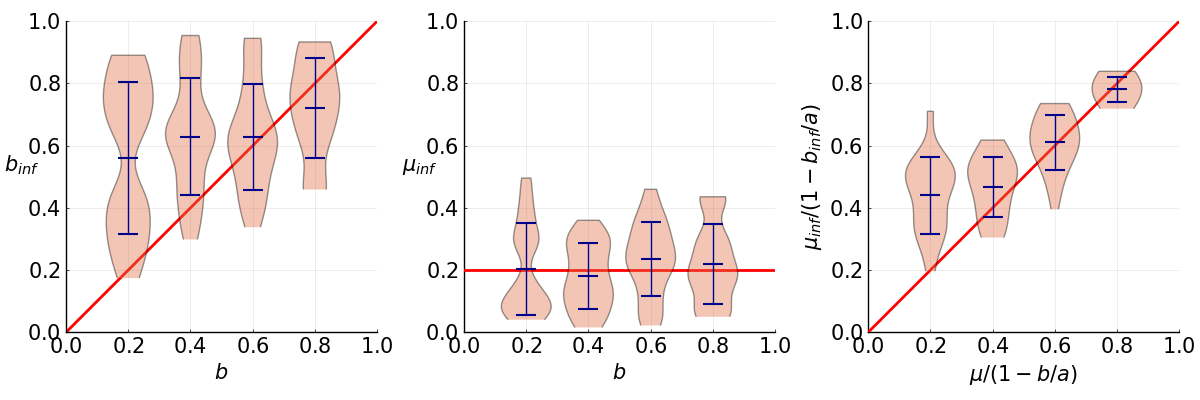

In [149]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 300, 270, 20, 1/3

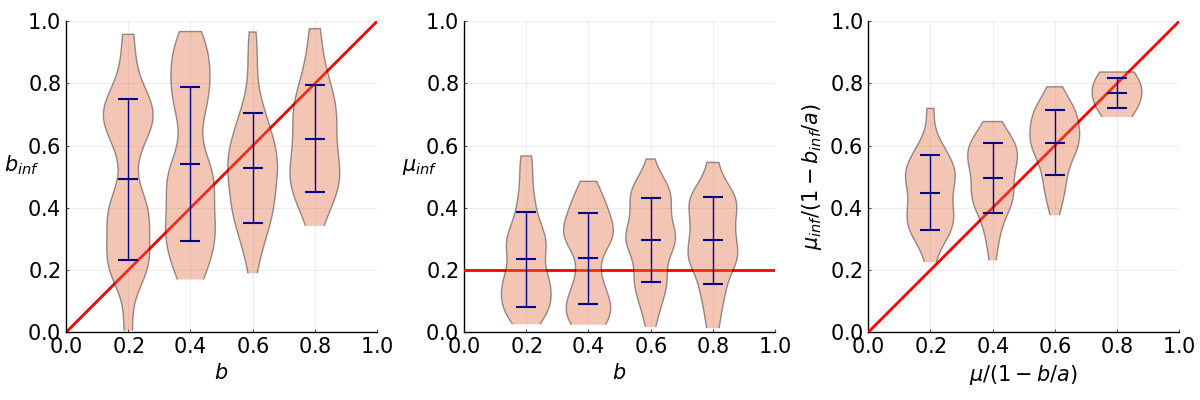

In [162]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 200, 270, 20, 1/3

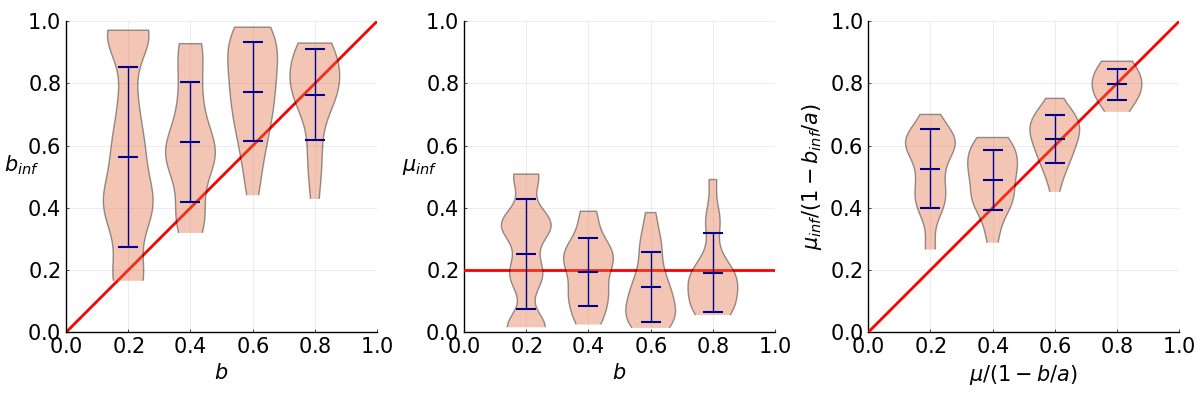

In [37]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 400, 200, 20, 1/3

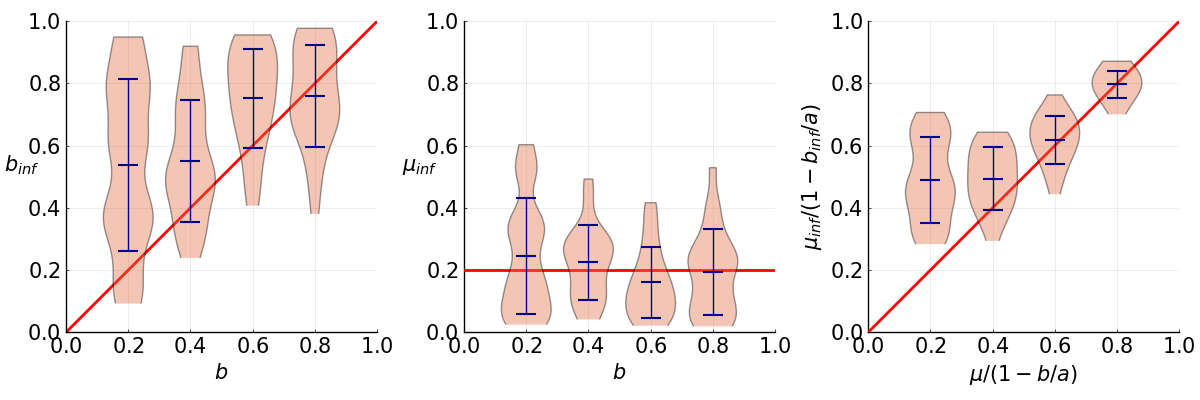

In [31]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 300, 200, 20, 1/3

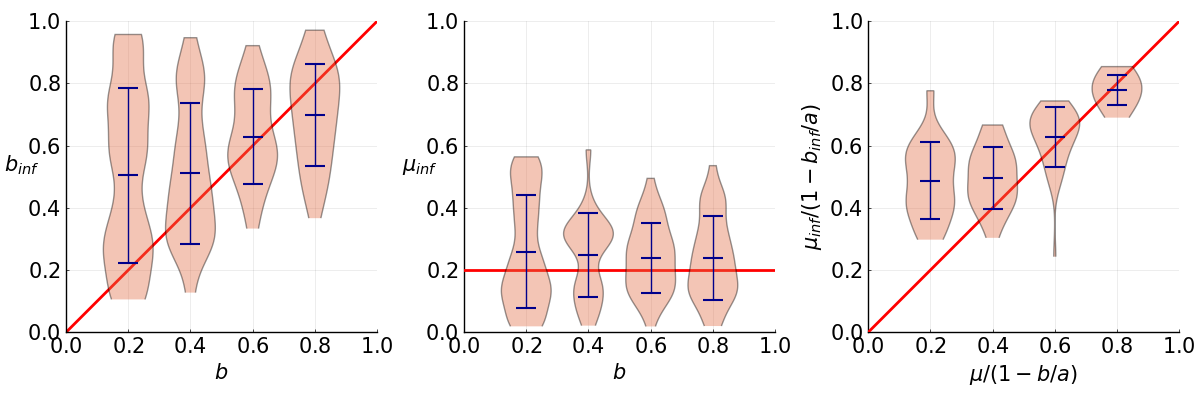

In [40]:
let mu = 0.2
    scalex = 5
    p = plot(layout=(1,3), legend=:none, yguidefontrotation=-90, size=(1200,400),
             aspect_ratio=scalex, xaxis=(L"b", (0,scalex)), yaxis=((0,1),0:0.2:1), guidefontsize=15, tickfont=15, xticks=(0:scalex, range(0,1,length=scalex+1)))

    plot!(p[1], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2.)
    violin!(p[1], ds*scalex, dfits, ylab=L"b_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[1], bins*scalex, mean.(dfits_binned), yerror = std.(dfits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    hline!(p[2], [mu], c=:red, lw=2.)
    violin!(p[2], ds*scalex, mufits, ylab=L"\mu_{inf}", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[2], bins*scalex, mean.(mufits_binned), yerror = std.(mufits_binned), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue)
    
    mubeta = [mufits_binned[i]./(1 .- dfits_binned[i]) for i =1:length(bins)]
    plot!(p[3], 0:scalex,range(0,1,length=scalex+1), c=:red, lw=2., xlab=L"\mu/(1-b/a)", yguidefontrotation=-0)
    violin!(p[3], ds*scalex, mufits./(1 .-dfits), ylab=L"\mu_{inf}/(1-b_{inf}/a)", marker = (5, 0.2, :darkblue), alpha=0.4)
    scatter!(p[3], bins*scalex, mean.(mubeta), yerror = std.(mubeta), marker = (:hline, 14, :darkblue), markerstrokecolor=:darkblue) 
end

> 200, 200, 20, 1/3

In [22]:
path = filter(row -> row.N==10000 && row.d == 0.4, tumorinfo).path |> rand
tumor = data_import(path);

┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth C:\Users\Arman Angaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:104


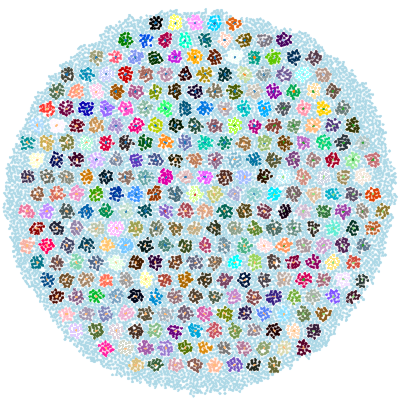

In [42]:
samples, sampletumor = TumorGrowth.multi_region_sequencing(tumor; n=300, cells_per_sample=15)
scene = TumorGrowth.plotting(tumor, color=:lightblue, size=(400,400))
cs = distinguishable_colors(length(samples))
for (i,sample) in enumerate(samples)
    TumorGrowth.plotting!(scene , sample, color=cs[i])
end
TumorGrowth.plotting_colored_mutations!(scene, sampletumor)